In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sklearn
# from numba import jit

# visual_drift_coef = 1.2
# visual_drift_min = 0.8
# memory_drift_coef = 0.7
# memory_drift_adaptive_coef = 0
# visual_drift_adaptive_coef = 0

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.7
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0

In [4]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [6]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'


seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'


seq_length = len(seq)

# window_sizes = [1,2,3,4,11]
window_sizes = [2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


visual_delay = 90
motor_delay = 50

diffusion = 2
threshold = 350
alpha = 0.9985
beta = 0.0005



param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]

motor_planning_param = [0.54899844, 0.3728446 , 0.32852511, 0.34319329, 0.25712932,
        0.20470091]

In [10]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta


@jit(nopython=True)
def exp_motor_planning(capacity, param):
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = 1 - theta[0]
    elif capacity >= 3:
        theta[0] = param[1]
        theta[1] = param[2]
        theta[2] = 1 - theta[0] - theta[1]
    # elif capacity >= 4:
    #     theta[0] = param[3]
    #     theta[1] = param[4]
    #     theta[2] = param[5]
    #     theta[3] = 1 - theta[0] - theta[1] - theta[2]
        
    return theta

In [12]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True
def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [14]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, motor_planning_param , planning_strategy, visual_delay, motor_delay, alpha, beta):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    effective_planning_capacity_motor = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
    motor_planning_coefs = exp_motor_planning(effective_planning_capacity, motor_planning_param)

    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef
            evidence[:, press] += motor_planning_coefs[press - current_press_planned] * drifts_memory_dt[:, press] * current_memory_coef

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            


        if (evidence[:, current_press_planned:min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)] >= threshold).any():
            visible_window_size -= 1       
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity, motor_planning_param)




        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity, motor_planning_param)




    return press_times, evidence

In [25]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3, motor_planning_param = 3, 
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001):
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.motor_planning_param = motor_planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, self.motor_planning_param,
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        motor_planning_coefs = planning_coefs / sum(planning_coefs)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence[finger, press] += motor_planning_coefs[press - current_press_planned] * self.memory_drifts[finger, press] * self.dt * current_memory_coef
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]


            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[: , current_press_planned:min(current_press_planned + visible_window_size, self.seq_length, current_press_planned + effective_planning_capacity)] >= self.threshold).any():
                visible_window_size -= 1

                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                motor_planning_coefs = planning_coefs / sum(planning_coefs)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
                motor_planning_coefs = planning_coefs / sum(planning_coefs)

                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

In [18]:
def check_param_condition(params):
    if params[0] < params[1]:
        return False
    if params[2] < params[3]:
        return False
    if params[3] < params[4]:
        return False

    if params[0] < params[2]:
        return False
    
    if params[1] < params[3]:
        return False

    if 1 < params[0]:
        return False
    if (params[0] + params[1] < 1):
        return False
    if (params[2] + params[3] + params[4] < params[0] + params[1]):
        return False


    else:
        return True

In [19]:
# from scipy.optimize import fmin
# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

# def loss(params, ipis_ideal):
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         corrs = []
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=4, planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi, _ = model.simulate()
#             corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             # corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#         # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):
#     # params = np.ones(9)/2
#     # params = np.array([0.86956522, 0.37807183, 0.83333333, 0.34722222, 0.14467593, 0.81632653, 0.3331945, 0.13599776, 0.05550929])
#     params = np.array([0.78947368, 0.41551247,0.73170732, 0.3569304 , 0.17411239,0.71428571, 0.34013605, 0.16196955, 0.07712836])
#     # res = fmin(loss, params, args = (model, ipi_ideal), maxiter=100, xtol= 1e-8, ftol=1e-8)
#     res = fmin(loss, params, args = (ipis_ideal,), maxiter=1000)
    
#     return res

In [20]:
# from scipy.optimize import fmin
# from scipy.optimize import minimize
# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 5]

# def loss(params, ipis_ideal):
#     corrs = []
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, 
#                 planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi, _ = model.simulate()
#             # corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#     # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):
#     # params = np.array(np.array([5,1, 0.5 ,1 , 0.1, 1, -0.2]))
#     params = np.array([10.34325211,  2.51997373,  0.14084574,  1.27775153,  0.07922256,
#         1.12502496, -0.03448899])
#     res = fmin(loss, params, args = (ipis_ideal,), maxiter=500)
#     # res = minimize(loss, params, args = (ipis_ideal,), constraints = constraints(params), method = 'SLSQP', options = {'maxiter': 1000, 'disp': True})
    
#     return res

In [22]:
# from pyswarm import pso

# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 10, 11, 12, 13]

# def loss(params, ipis_ideal):
#     corrs = []
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3,
#                   planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi_mean = np.array([])
#             n = 100
#             for _ in range(n):
#                 ipi, _ = model.simulate()
#                 ipi_mean = np.append(ipi_mean, ipi)
#             # ipi, _ = model.simulate()
#             ipi = ipi_mean.reshape(n, -1)
#             ipi = ipi.mean(axis = 0)
#             # corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             # corrs.append(np.linalg.norm(np.array([ipi[idx] for idx in optimzied_inds]) - np.array([ipis_ideal[window][idx] for idx in optimzied_inds])))
#             corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#     # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):
#     # params = np.array(np.array([5,1, 0.5 ,1 , 0.1, 1, -0.2]))
#     # lb = [5, 0, -1, 0, -1, 0, -1]
#     # ub = [20, 5, 1, 7, 1, 5, 1 ]


#     lb = np.zeros(5)
#     ub = np.ones(5)
    
#     # params_opt, loss_opt = pso(loss, lb, ub, args=(ipis_ideal,), maxiter=500, swarmsize=100, debug=True, phip = 0, phig=0.9, omega=0.2)
#     params_opt, loss_opt = pso(loss, lb, ub, args=(ipis_ideal,), maxiter=20, swarmsize=10000, debug=True)

#     # res = minimize(loss, params, args = (ipis_ideal,), constraints = constraints(params), method = 'SLSQP', options = {'maxiter': 1000, 'disp': True})
    
#     return params_opt, loss_opt

In [23]:


ipis_ideal = {
    1: [644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93],
    2: [710.87, 268.27, 348.47, 325.0, 361.6, 340.93, 362.53, 350.53, 355.2, 349.2, 359.93, 368.93, 384.27, 273.73],
    3: [727.13, 251.67, 257.93, 326.8, 322.27, 319.47, 314.13, 322.33, 330.73, 331.8, 341.27, 319.6, 334.4, 227.87],
    4: [745.93, 253.4, 270.13, 294.67, 307.6, 311.2, 315.13, 317.33, 318.0, 320.93, 332.33, 325.8, 306.07, 217.8]
}




In [182]:
# optimize(ipis_ideal)

No constraints given.


SystemError: CPUDispatcher(<function simulate_ddm at 0x2a0c023a0>) returned a result with an error set

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_155/62776389.py:48: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


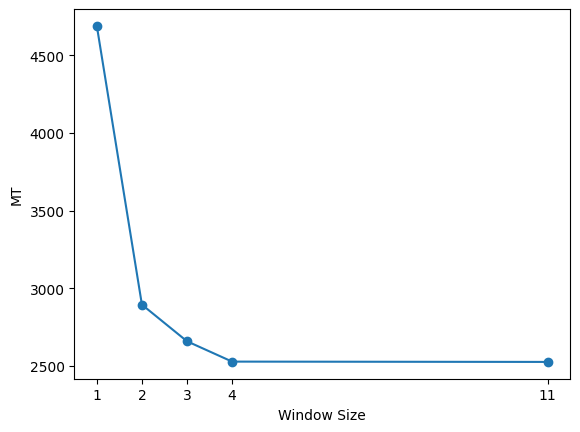

CPU times: user 6.85 s, sys: 75 ms, total: 6.92 s
Wall time: 6.96 s


In [34]:
%%time 
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param
    , motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


dict_values([6958.0, 4826.0, 4291.0, 4064.0, 4064.0])


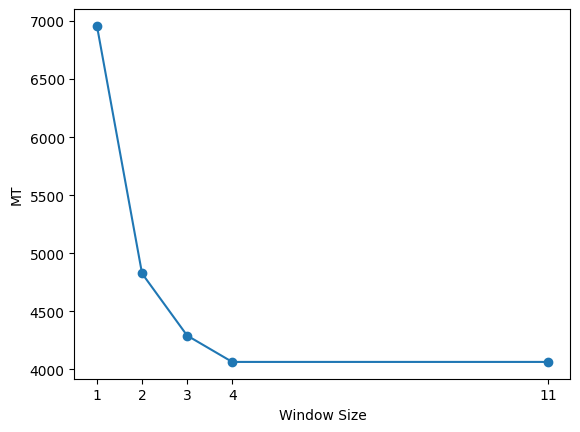

CPU times: user 3.89 s, sys: 75 ms, total: 3.96 s
Wall time: 3.95 s


In [35]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, seq_length=seq_length,
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
     alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

print(MT_mean.values())

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


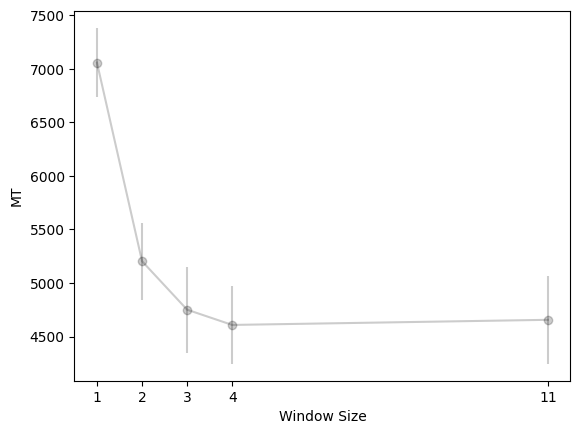

CPU times: user 7.89 s, sys: 122 ms, total: 8.01 s
Wall time: 8.06 s


In [36]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 100
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, 
    planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', color = 'black', alpha = 0.2)
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


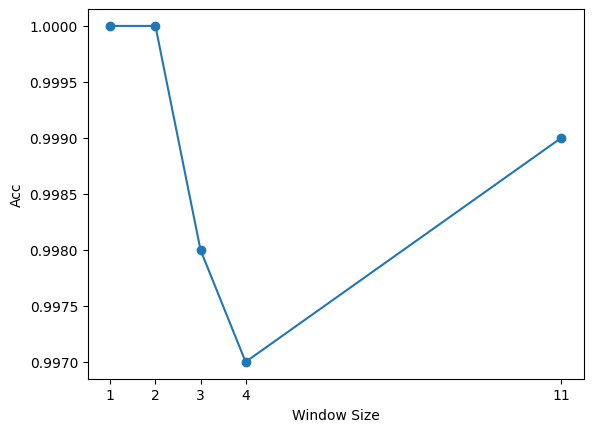

CPU times: user 1min 16s, sys: 912 ms, total: 1min 17s
Wall time: 1min 18s


In [38]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 1000
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold , window_size=window, visual_delay=visual_delay, motor_delay = motor_delay
    , planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(check_evidence_to_seq(evidence, random_seq))


#Calculating mean and std for each window size
MT_mean = {window: np.sum(MT_vals) for window, MT_vals in MT.items()}
# MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

# plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.errorbar(MT_mean.keys(), np.array(list(MT_mean.values()))/num_sims, fmt='-o')

plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Acc')
plt.show()


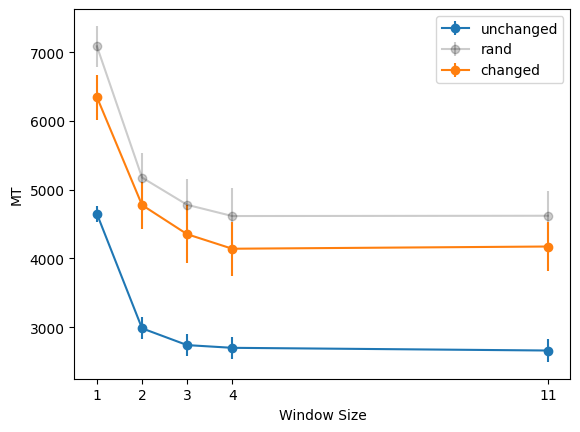

CPU times: user 21.4 s, sys: 258 ms, total: 21.6 s
Wall time: 21.9 s


In [40]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
num_sims = 100
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, 
    window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion,
     threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
     motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


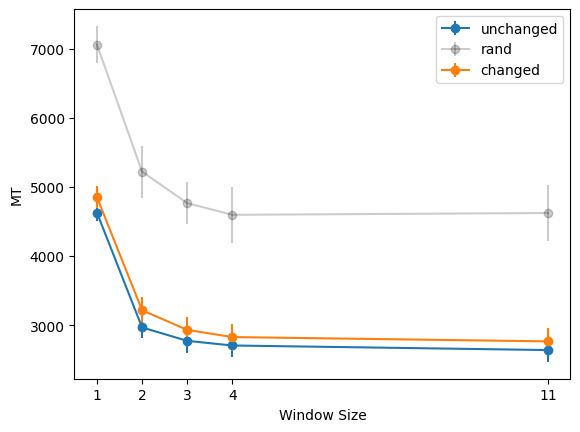

CPU times: user 20.6 s, sys: 288 ms, total: 20.9 s
Wall time: 21.1 s


In [41]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 100
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
                                          motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
                                          planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
                                          planning_param=param, motor_planning_param=motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


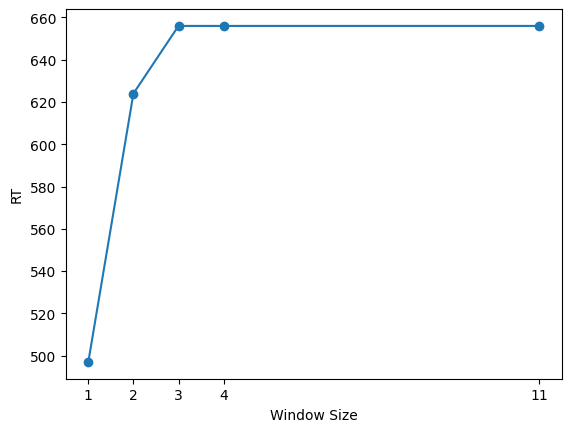

CPU times: user 214 ms, sys: 4.11 ms, total: 218 ms
Wall time: 135 ms


In [42]:
%%time
RT = {window: [] for window in window_sizes}
num_sims = 1
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = 0, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.show()


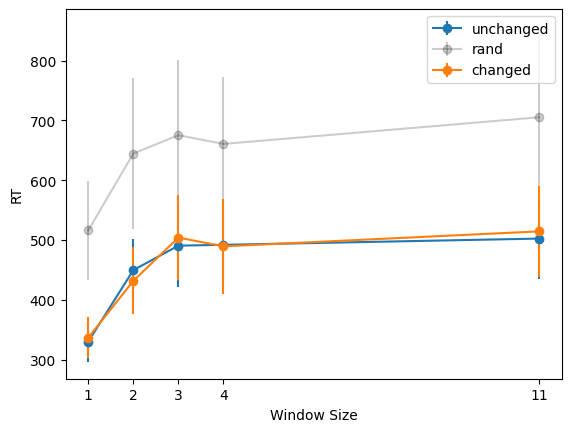

CPU times: user 10.4 s, sys: 230 ms, total: 10.7 s
Wall time: 10.7 s


In [52]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

RT = {window: [] for window in window_sizes}
num_sims = 50
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
    window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
     alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])



visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
     alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq_changed, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold,
     window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
      alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


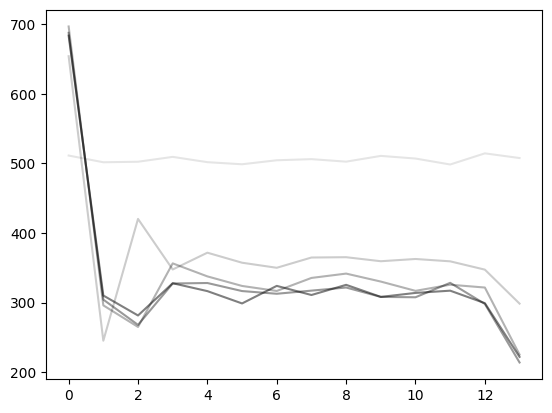

CPU times: user 37.7 s, sys: 746 ms, total: 38.4 s
Wall time: 38.6 s


In [ ]:
%%time 
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, dt= 1)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.ylim([100,550])
# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


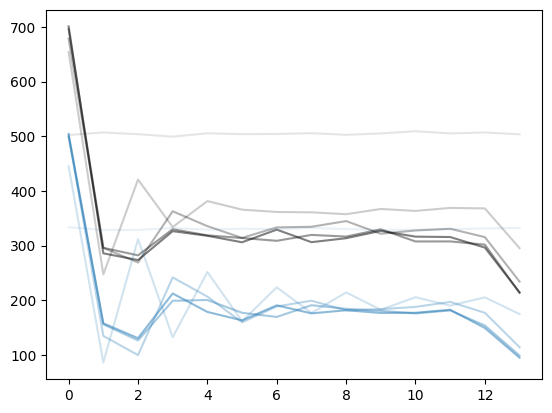

CPU times: user 1min 10s, sys: 918 ms, total: 1min 11s
Wall time: 1min 11s


In [44]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
     alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, 
    memory_drifts, diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
     alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))

# plt.legend()
# plt.ylim([100,700])
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


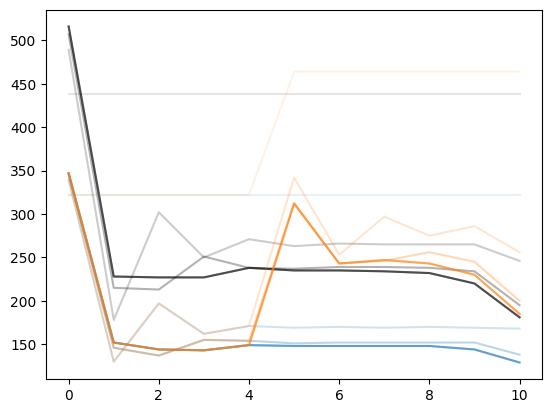

In [ ]:

num_sims = 50

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0
                                          , threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, window_size=window, 
                                          visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
                                          threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_42868/62776389.py:48: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


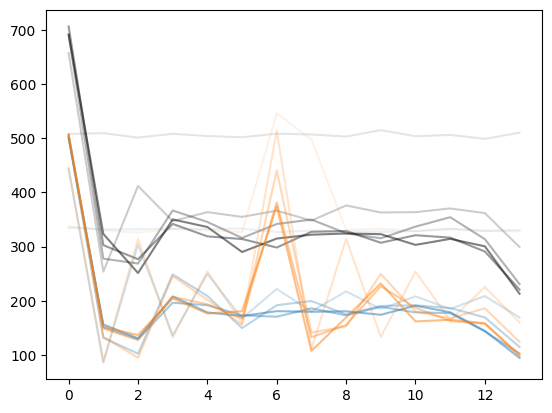

In [24]:

num_sims = 300

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, motor_planning_param= motor_planning_param,
              alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, motor_planning_param= motor_planning_param,
              alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, motor_planning_param= motor_planning_param,
              alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))

# plt.ylim([100,550])
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()
